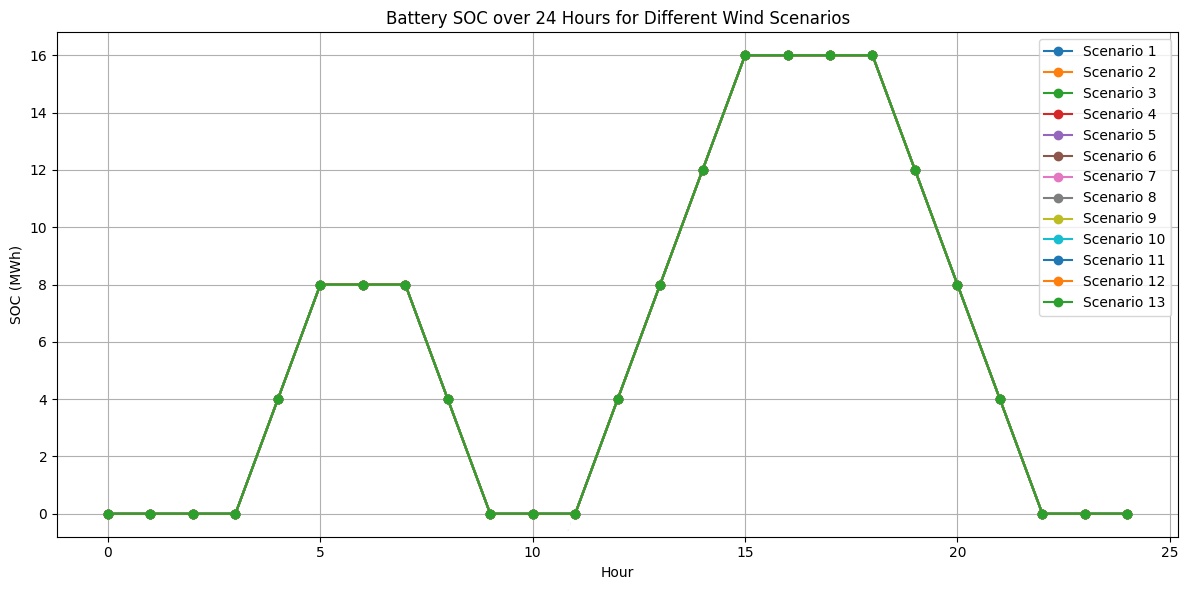

In [ ]:
import pulp
import pandas as pd
import matplotlib.pyplot as plt

# =====================
# Load input data
# =====================
df = pd.read_csv("input_data.csv")

T = range(24)  # Time horizon: 24 hours (0–23)
num_scenarios = 13  # Number of wind scenarios

price = df["price"]

# Store results for all scenarios
results = {}

# =====================
# Loop over scenarios
# =====================
for s in range(num_scenarios):
    wind = df[f"scenario_{s + 1}"]

    # Optimization model
    model = pulp.LpProblem(f"Battery_Wind_Scenario_{s + 1}", pulp.LpMaximize)

    # Decision variables
    c = pulp.LpVariable.dicts("charge", T, lowBound=0)  # Charging power
    d = pulp.LpVariable.dicts("discharge", T, lowBound=0)  # Discharging power
    soc = pulp.LpVariable.dicts("soc", range(25), lowBound=0, upBound=16)
    y = pulp.LpVariable.dicts("mode", T, cat="Binary")  # 0: charge, 1: discharge

    # =====================
    # Objective function
    # =====================
    model += pulp.lpSum(price[t] * (d[t] + wind[t] - c[t]) for t in T)

    # =====================
    # SOC constraints
    # =====================
    model += soc[0] == 0
    model += soc[24] == 0

    for t in T:
        model += soc[t + 1] == soc[t] + 0.8 * c[t] - d[t]
        model += c[t] <= 5 * (1 - y[t])  # Charging limit
        model += d[t] <= 4 * y[t]  # Discharging limit

    # Battery cycle constraint
    model += pulp.lpSum(d[t] for t in T) <= 32

    # =====================
    # Solve (quiet mode)
    # =====================
    solver = pulp.PULP_CBC_CMD(msg=False)
    model.solve(solver)

    # =====================
    # Store results
    # =====================
    results[s] = {
        "SOC": [soc[t].varValue for t in range(25)],
        "charge": [c[t].varValue for t in T],
        "discharge": [d[t].varValue for t in T],
    }

# =====================
# Plot SOC comparison
# =====================
plt.figure(figsize=(12, 6))

for s in range(num_scenarios):
    plt.plot(range(25), results[s]["SOC"], marker="o", label=f"Scenario {s + 1}")

plt.xlabel("Hour")
plt.ylabel("SOC (MWh)")
plt.title("Battery SOC over 24 Hours for Different Wind Scenarios")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
